[Reference]
* https://www.kaggle.com/guntherthepenguin/fastai-v1-densenet169

 **Brief description of the problem and data**
 
 In this dataset, you are provided with a large number of small pathology images to classify. Files are named with an image id. The train_labels.csv file provides the ground truth for the images in the train folder. You are predicting the labels for the images in the test folder. A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label. This outer region is provided to enable fully-convolutional models that do not use zero-padding, to ensure consistent behavior when applied to a whole-slide image.

The original PCam dataset contains duplicate images due to its probabilistic sampling, however, the version presented on Kaggle does not contain duplicates. We have otherwise maintained the same data and splits as the PCam benchmark.

**Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data**

In [1]:
# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# import matplotlib.pyplot as plt
# from PIL import Image
# import tensorflow as tf
# import os
# import multiprocessing
# from tqdm import tqdm
# from PIL import ImageDraw
# train_on_gpu = True

# Path = '/kaggle/input/histopathologic-cancer-detection/'

In [2]:
# train_df = pd.read_csv(Path + 'train_labels.csv')
# train_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [3]:
# df_samples = pd.read_csv(Path + 'sample_submission.csv')

In [4]:
# train = "/kaggle/input/histopathologic-cancer-detection/train/"
# test = "/kaggle/input/histopathologic-cancer-detection/test"

# print("Number of training images: {}".format(len(os.listdir(train))))
# print("Number of test images: {}".format(len(os.listdir(test))))

Number of training images: 220025
Number of test images: 57458


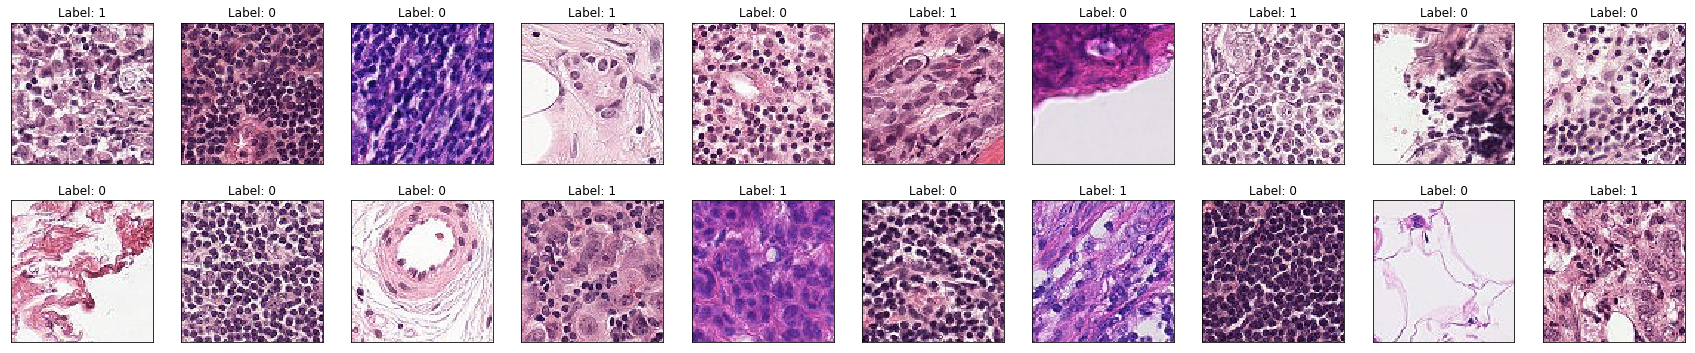

In [5]:
# fig = plt.figure(figsize=(30, 6))
# train_imgs = os.listdir(Path+"train")
# for idx, img in enumerate(np.random.choice(train_imgs, 20)):
#     ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
#     im = Image.open(Path+"train/" + img)
#     plt.imshow(im)
#     label = train_df.loc[train_df['id'] == img.split('.')[0], 'label'].values[0]
#     ax.set_title(f'Label: {label}')

In [6]:
# missing_values = train_df.isnull().sum()
# missing_values

id       0
label    0
dtype: int64

In [7]:
# print(train_df.shape)
# print(train_df.columns)

(220025, 2)
Index(['id', 'label'], dtype='object')


In [8]:
# np.array(im).shape

(96, 96, 3)

In [9]:
# train_df['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

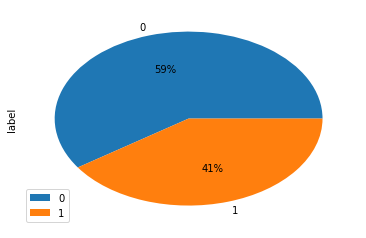

In [10]:
#train_df['label'].value_counts().plot(kind='pie', legend=True, autopct='%1.0f%%')

**DModel Architecture**

Resnet101 Architecture visualization: http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006

xception

**Results and Analysis**

In [16]:

!ls ../input

torch.cuda.get_device_name(0)

histopathologic-cancer-detection


'Tesla P100-PCIE-16GB'

In [6]:
import fastai
from fastai.imports import *
from fastai.vision import *
from fastai.metrics import *
from fastai.gen_doc.nbdoc import *
print('fast.ai version:{}'.format(fastai.__version__))

fast.ai version:1.0.39


In [7]:
WORK_DIR = os.getcwd()

In [8]:
show_doc(get_transforms)

<h4 id="get_transforms"><code>get_transforms</code><a href="https://github.com/fastai/fastai/blob/master/fastai/vision/transform.py#L267" class="source_link">[source]</a></h4>

> <code>get_transforms</code>(<b>`do_flip`</b>:`bool`=<b><i>`True`</i></b>, <b>`flip_vert`</b>:`bool`=<b><i>`False`</i></b>, <b>`max_rotate`</b>:`float`=<b><i>`10.0`</i></b>, <b>`max_zoom`</b>:`float`=<b><i>`1.1`</i></b>, <b>`max_lighting`</b>:`float`=<b><i>`0.2`</i></b>, <b>`max_warp`</b>:`float`=<b><i>`0.2`</i></b>, <b>`p_affine`</b>:`float`=<b><i>`0.75`</i></b>, <b>`p_lighting`</b>:`float`=<b><i>`0.75`</i></b>, <b>`xtra_tfms`</b>:`Optional`\[`Collection`\[[`Transform`](/vision.image.html#Transform)\]\]=<b><i>`None`</i></b>) → `Collection`\[[`Transform`](/vision.image.html#Transform)\]

Utility func to easily create a list of flip, rotate, [`zoom`](/vision.transform.html#_zoom), warp, lighting transforms.  

In [9]:
show_doc(ImageDataBunch.from_csv)

<h4 id="ImageDataBunch.from_csv"><code>from_csv</code><a href="https://github.com/fastai/fastai/blob/master/fastai/vision/data.py#L128" class="source_link">[source]</a></h4>

> <code>from_csv</code>(<b>`path`</b>:`PathOrStr`, <b>`folder`</b>:`PathOrStr`=<b><i>`'.'`</i></b>, <b>`sep`</b>=<b><i>`None`</i></b>, <b>`csv_labels`</b>:`PathOrStr`=<b><i>`'labels.csv'`</i></b>, <b>`valid_pct`</b>:`float`=<b><i>`0.2`</i></b>, <b>`fn_col`</b>:`int`=<b><i>`0`</i></b>, <b>`label_col`</b>:`int`=<b><i>`1`</i></b>, <b>`suffix`</b>:`str`=<b><i>`''`</i></b>, <b>`header`</b>:`Union`\[`int`, `str`, `NoneType`\]=<b><i>`'infer'`</i></b>, <b>`kwargs`</b>:`Any`) → `ImageDataBunch`

Create from a csv file in `path/csv_labels`.  

In [10]:
param_transforms = {
    'flip_vert':True,
    'max_rotate':90,
    'max_zoom':1,
    'max_warp':None,
    'max_lighting':None,
}
params = {'path': Path('../input/histopathologic-cancer-detection'),
          'csv_labels':'train_labels.csv',
          'ds_tfms':get_transforms(**param_transforms),
          'suffix':'.tif',
          'folder':'train',
          'test':'test',
          'size':32,
          'bs':128,
          'num_workers':0,
         }
data = ImageDataBunch.from_csv(**params).normalize(imagenet_stats)
data

ImageDataBunch;

Train: LabelList
y: CategoryList (176020 items)
[Category 0, Category 0, Category 0, Category 0, Category 1]...
Path: ../input/histopathologic-cancer-detection
x: ImageItemList (176020 items)
[Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96)]...
Path: ../input/histopathologic-cancer-detection;

Valid: LabelList
y: CategoryList (44005 items)
[Category 0, Category 0, Category 0, Category 1, Category 0]...
Path: ../input/histopathologic-cancer-detection
x: ImageItemList (44005 items)
[Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96)]...
Path: ../input/histopathologic-cancer-detection;

Test: LabelList
y: CategoryList (57458 items)
[Category 0, Category 0, Category 0, Category 0, Category 0]...
Path: ../input/histopathologic-cancer-detection
x: ImageItemList (57458 items)
[Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96)]...
Path: ../input/

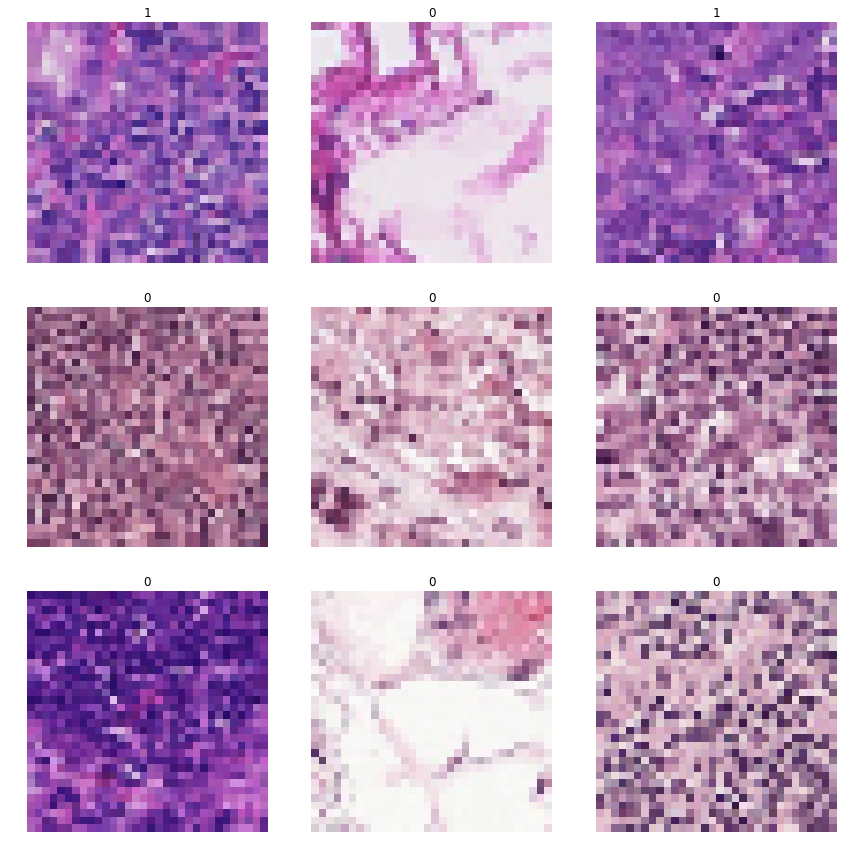

In [13]:
data.show_batch(rows=3)

In [35]:
learn = create_cnn(data, models.resnet101, metrics=accuracy, path='.', model_dir='.')

In [14]:
!ls /kaggle/input/

histopathologic-cancer-detection


In [38]:
learn.load('histopathologic_cancer_detection')

Learner(data=ImageDataBunch;

Train: LabelList
y: CategoryList (176020 items)
[Category 0, Category 0, Category 0, Category 0, Category 1]...
Path: ../input/histopathologic-cancer-detection
x: ImageItemList (176020 items)
[Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96)]...
Path: ../input/histopathologic-cancer-detection;

Valid: LabelList
y: CategoryList (44005 items)
[Category 0, Category 0, Category 0, Category 1, Category 0]...
Path: ../input/histopathologic-cancer-detection
x: ImageItemList (44005 items)
[Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96)]...
Path: ../input/histopathologic-cancer-detection;

Test: LabelList
y: CategoryList (57458 items)
[Category 0, Category 0, Category 0, Category 0, Category 0]...
Path: ../input/histopathologic-cancer-detection
x: ImageItemList (57458 items)
[Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96)]...
Pa

In [17]:
learn.unfreeze()
# learn.fit_one_cycle(16)
#learn.fit_one_cycle(16,slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy
1,0.556182,0.456265,0.793501
2,0.413237,0.372360,0.832928
3,0.351117,0.329669,0.855266
4,0.318579,0.293366,0.873333
5,0.286535,0.275884,0.883990
6,0.271489,0.258816,0.893217
7,0.256899,0.244637,0.901398
8,0.249015,0.233783,0.904852
9,0.244062,0.229194,0.906533
10,0.234544,0.233442,0.908533


In [18]:
#learn.save('histopathologic_cancer_detection')

In [37]:
#learn.recorder.plot_losses()
#plt.ylim([0,0.5])

AttributeError: 'Learner' object has no attribute 'recorder'

In [40]:
# Check if DatasetType loaded
# It's depend on difference between fast.ai version v1.0.39/v1.0.36.
try:
    DatasetType
except:
    from fastai import DatasetType

In [ ]:
try:
    # TTA cause error @fast.ai v1.0.39
    preds, _ = learn.TTA(ds_type=DatasetType.Test)
    print('Predict w/ test time augument done.')
except:
    preds, _ = learn.get_preds(DatasetType.Test)

In [22]:
preds

tensor([[0.3720, 0.6280],
        [0.9705, 0.0295],
        [0.8255, 0.1745],
        ...,
        [0.2229, 0.7771],
        [0.9957, 0.0043],
        [0.9951, 0.0049]])

In [23]:
ids = [file.stem for file in data.test_ds.x.items]
ids[:5]

['a7ea26360815d8492433b14cd8318607bcf99d9e',
 '59d21133c845dff1ebc7a0c7cf40c145ea9e9664',
 '5fde41ce8c6048a5c2f38eca12d6528fa312cdbb',
 'bd953a3b1db1f7041ee95ff482594c4f46c73ed0',
 '523fc2efd7aba53e597ab0f69cc2cbded7a6ce62']

In [24]:
data.classes

[0, 1]

In [25]:
df=pd.read_csv('../input/histopathologic-cancer-detection/sample_submission.csv').set_index('id')
df.head()

,label
id,
0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
95596b92e5066c5c52466c90b69ff089b39f2737,0
248e6738860e2ebcf6258cdc1f32f299e0c76914,0
2c35657e312966e9294eac6841726ff3a748febf,0
145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0


In [26]:
df.loc[ids,'label'] = preds[:,1].numpy()
df = df.reset_index()
df.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0.043048
1,95596b92e5066c5c52466c90b69ff089b39f2737,0.624411
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0.001281
3,2c35657e312966e9294eac6841726ff3a748febf,0.592186
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0.353799


In [30]:
df.to_csv('submission.csv', index=None)

**Conclusion**

In [34]:
!ls -la

total 526340
drwxr-xr-x 2 root root      4096 Aug 19 10:59 .
drwxr-xr-x 5 root root      4096 Aug 19 06:55 ..
-rw-r--r-- 1 root root 535970817 Aug 19 10:33 histopathologic_cancer_detection.pth
-rw-r--r-- 1 root root   2988839 Aug 19 11:06 submission.csv
